# ⚠️ UPDATED DEDUPLICATION STRATEGY ⚠️

**New Prioritization Strategy: Preserve Training Data**

The deduplication strategy has been updated to prioritize keeping training data over validation/test data:

1. **Train + Val duplicates** → Remove from **val** (preserve training data)
2. **Train + Test duplicates** → Remove from **test** (preserve training data)  
3. **Val + Test duplicates** → Remove from **val** (preserve test data over validation)
4. **All three splits** → Remove from **val AND test** (preserve training data at all costs)

**Rationale**: Training data is the most critical for model learning. It's better to have a smaller but clean validation/test set than to lose valuable training examples.

# CoDet Dataset Data Leakage Analysis

This notebook compares the train, validation, and test sets of the CoDet dataset to check for data leakage.
Data leakage occurs when information from the validation or test set inadvertently appears in the training set,
leading to overly optimistic performance estimates.

## 1. Setup and Import Libraries

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
from collections import Counter, defaultdict
from typing import List, Dict, Set, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load Dataset Splits

In [2]:
from data.dataset import CoDeTM4

# Load the dataset splits
print("Loading CoDet dataset splits...")
train, val, test = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)

print(f"Train set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")
print(f"Total samples: {len(train) + len(val) + len(test)}")

Loading CoDet dataset splits...
Train set size: 405069
Validation set size: 47734
Test set size: 47749
Total samples: 500552


## 3. Basic Dataset Statistics

In [3]:
def analyze_split_statistics(split_data, split_name):
    """Analyze basic statistics for a dataset split"""
    print(f"\n=== {split_name} Set Statistics ===")
    print(f"Size: {len(split_data)}")
    
    # Language distribution
    lang_counts = Counter(split_data['language'])
    print(f"\nLanguage distribution:")
    for lang, count in lang_counts.items():
        percentage = (count / len(split_data)) * 100
        print(f"  {lang}: {count} ({percentage:.1f}%)")
    
    # Target distribution
    target_counts = Counter(split_data['target_binary'])
    print(f"\nTarget distribution:")
    for target, count in target_counts.items():
        percentage = (count / len(split_data)) * 100
        print(f"  Class {target}: {count} ({percentage:.1f}%)")
    
    return lang_counts, target_counts

# Analyze each split
train_lang, train_target = analyze_split_statistics(train, "Train")
val_lang, val_target = analyze_split_statistics(val, "Validation")
test_lang, test_target = analyze_split_statistics(test, "Test")


=== Train Set Statistics ===
Size: 405069

Language distribution:
  python: 149763 (37.0%)
  java: 140875 (34.8%)
  cpp: 114431 (28.2%)

Target distribution:
  Class 0: 197087 (48.7%)
  Class 1: 207982 (51.3%)

=== Validation Set Statistics ===
Size: 47734

Language distribution:
  python: 17685 (37.0%)
  java: 16651 (34.9%)
  cpp: 13398 (28.1%)

Target distribution:
  Class 0: 24571 (51.5%)
  Class 1: 23163 (48.5%)

=== Test Set Statistics ===
Size: 47749

Language distribution:
  java: 16643 (34.9%)
  python: 17715 (37.1%)
  cpp: 13391 (28.0%)

Target distribution:
  Class 0: 24563 (51.4%)
  Class 1: 23186 (48.6%)


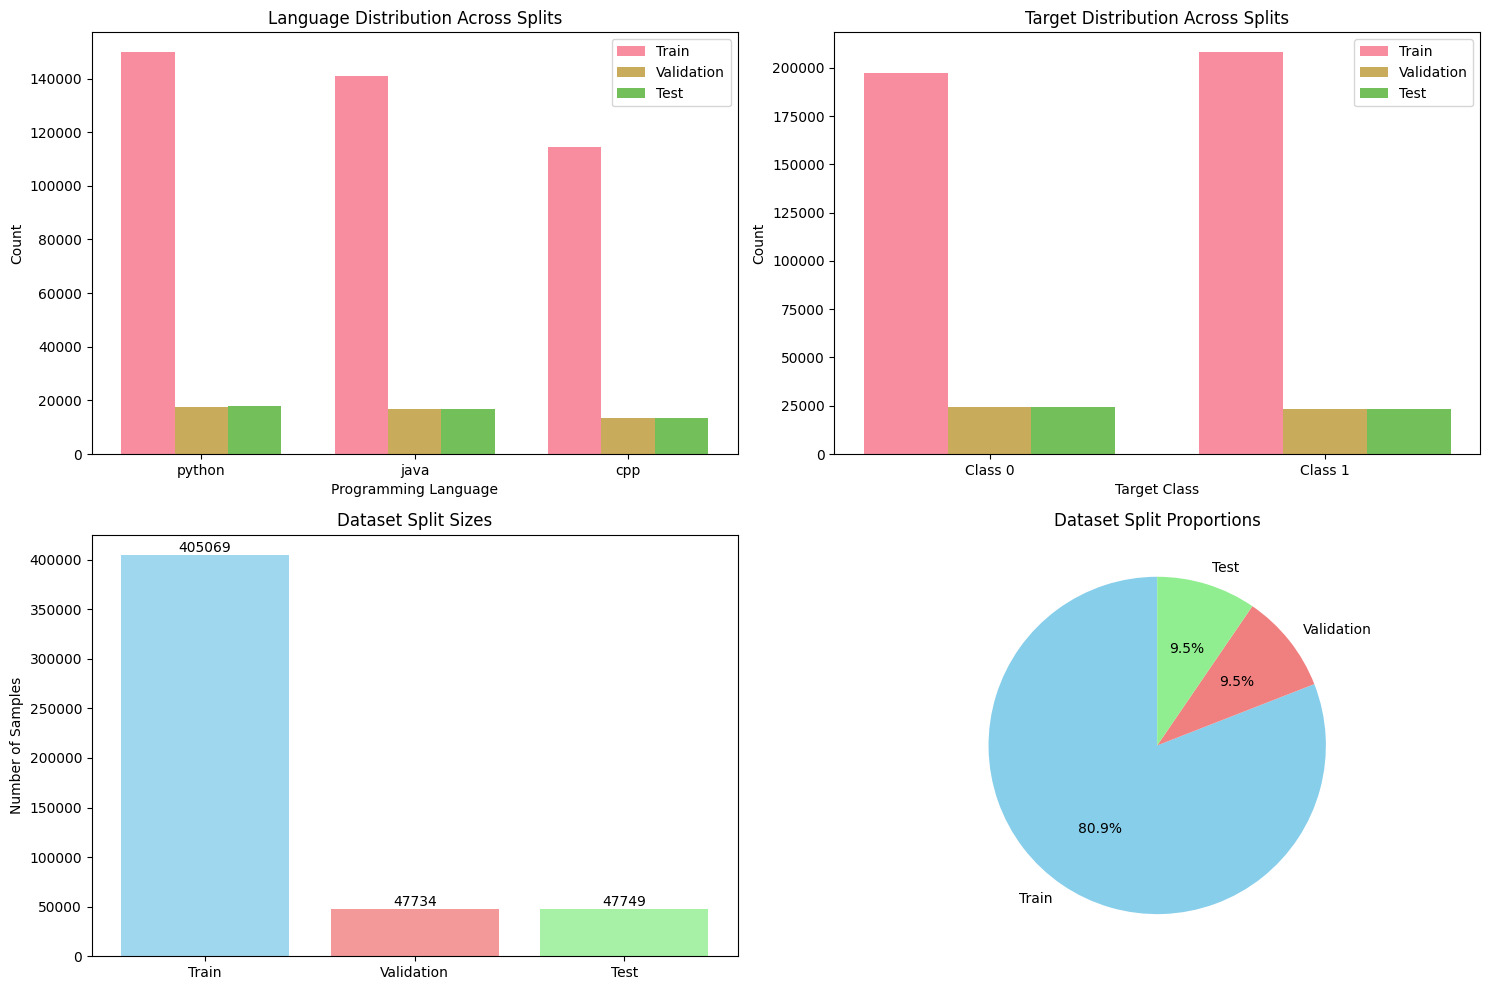

In [4]:
# Create visualization of split distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Language distribution across splits
languages = ['python', 'java', 'cpp']
train_lang_counts = [train_lang.get(lang, 0) for lang in languages]
val_lang_counts = [val_lang.get(lang, 0) for lang in languages]
test_lang_counts = [test_lang.get(lang, 0) for lang in languages]

x = np.arange(len(languages))
width = 0.25

axes[0, 0].bar(x - width, train_lang_counts, width, label='Train', alpha=0.8)
axes[0, 0].bar(x, val_lang_counts, width, label='Validation', alpha=0.8)
axes[0, 0].bar(x + width, test_lang_counts, width, label='Test', alpha=0.8)
axes[0, 0].set_xlabel('Programming Language')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Language Distribution Across Splits')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(languages)
axes[0, 0].legend()

# Target distribution across splits
targets = [0, 1]
train_target_counts = [train_target.get(target, 0) for target in targets]
val_target_counts = [val_target.get(target, 0) for target in targets]
test_target_counts = [test_target.get(target, 0) for target in targets]

x = np.arange(len(targets))
axes[0, 1].bar(x - width, train_target_counts, width, label='Train', alpha=0.8)
axes[0, 1].bar(x, val_target_counts, width, label='Validation', alpha=0.8)
axes[0, 1].bar(x + width, test_target_counts, width, label='Test', alpha=0.8)
axes[0, 1].set_xlabel('Target Class')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Target Distribution Across Splits')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([f'Class {t}' for t in targets])
axes[0, 1].legend()

# Split sizes
split_names = ['Train', 'Validation', 'Test']
split_sizes = [len(train), len(val), len(test)]
colors = ['skyblue', 'lightcoral', 'lightgreen']

axes[1, 0].bar(split_names, split_sizes, color=colors, alpha=0.8)
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].set_title('Dataset Split Sizes')
for i, size in enumerate(split_sizes):
    axes[1, 0].text(i, size + 100, str(size), ha='center', va='bottom')

# Pie chart of split proportions
axes[1, 1].pie(split_sizes, labels=split_names, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1, 1].set_title('Dataset Split Proportions')

plt.tight_layout()
plt.show()

## 4. Check for Duplicate Code Samples

In [5]:
def find_exact_duplicates(datasets: Dict[str, List], code_field: str = 'cleaned_code') -> Dict[str, Set[Tuple[str, int]]]:
    """Find exact duplicate code samples across dataset splits"""
    
    # Create a mapping from code to (split_name, index) pairs
    code_to_splits = defaultdict(list)
    
    for split_name, dataset in datasets.items():
        for idx, sample in enumerate(dataset):
            code = sample[code_field]
            code_to_splits[code].append((split_name, idx))
    
    # Find codes that appear in multiple splits
    duplicates = {}
    for code, occurrences in code_to_splits.items():
        if len(occurrences) > 1:
            splits_involved = set(split for split, _ in occurrences)
            if len(splits_involved) > 1:  # Code appears in multiple splits
                duplicates[code] = set(occurrences)
    
    return duplicates

# Check for exact duplicates
datasets = {'train': train, 'val': val, 'test': test}

print("Checking for exact duplicate code samples...")
exact_duplicates = find_exact_duplicates(datasets, 'cleaned_code')

print(f"\nFound {len(exact_duplicates)} unique code samples that appear in multiple splits")

if exact_duplicates:
    # Analyze which splits have overlaps
    overlap_counts = defaultdict(int)
    total_overlapping_samples = 0
    
    for code, occurrences in exact_duplicates.items():
        splits_involved = sorted(set(split for split, _ in occurrences))
        overlap_key = '-'.join(splits_involved)
        overlap_counts[overlap_key] += 1
        total_overlapping_samples += len(occurrences)
    
    print(f"\nOverlap analysis:")
    for overlap_type, count in overlap_counts.items():
        print(f"  {overlap_type}: {count} duplicate code samples")
    
    print(f"\nTotal overlapping sample instances: {total_overlapping_samples}")
    
    # Show a few examples
    print(f"\nFirst 3 examples of duplicate code:")
    for i, (code, occurrences) in enumerate(list(exact_duplicates.items())[:3]):
        print(f"\nExample {i+1}:")
        print(f"Code length: {len(code)} characters")
        print(f"Appears in: {[(split, idx) for split, idx in occurrences]}")
        print(f"Code preview: {code[:200]}..." if len(code) > 200 else f"Code: {code}")
else:
    print("No exact duplicate code samples found across splits!")

Checking for exact duplicate code samples...

Found 1234 unique code samples that appear in multiple splits

Overlap analysis:
  train-val: 555 duplicate code samples
  test-train: 595 duplicate code samples
  test-train-val: 35 duplicate code samples
  test-val: 49 duplicate code samples

Total overlapping sample instances: 3186

First 3 examples of duplicate code:

Example 1:
Code length: 44 characters
Appears in: [('train', 11213), ('val', 30791)]
Code: inline int gleft(int no) { return no << 1; }

Example 2:
Code length: 59 characters
Appears in: [('train', 32513), ('val', 29254)]
Code: inline long long ab(long long x) { return x < 0 ? -x : x; }

Example 3:
Code length: 240 characters
Appears in: [('train', 35868), ('val', 32100)]
Code preview: public Matrix4f setPerspectiveOffCenter(float fovy, float offAngleX, float offAngleY,
            float aspect, float zNear, float zFar) {
        return setPerspectiveOffCenter(fovy, offAngleX, offAn...


## 5. Check for Similar Code Using Hashing

In [6]:
def compute_code_hashes(datasets: Dict[str, List], code_field: str = 'cleaned_code') -> Dict[str, Dict[str, Tuple[str, int]]]:
    """Compute MD5 and SHA256 hashes for all code samples"""
    
    hash_to_location = {
        'md5': defaultdict(list),
        'sha256': defaultdict(list)
    }
    
    for split_name, dataset in datasets.items():
        for idx, sample in enumerate(dataset):
            code = sample[code_field]
            code_bytes = code.encode('utf-8')
            
            # Compute hashes
            md5_hash = hashlib.md5(code_bytes).hexdigest()
            sha256_hash = hashlib.sha256(code_bytes).hexdigest()
            
            hash_to_location['md5'][md5_hash].append((split_name, idx))
            hash_to_location['sha256'][sha256_hash].append((split_name, idx))
    
    return hash_to_location

def find_hash_duplicates(hash_to_location: Dict[str, Dict[str, List]]) -> Dict[str, Dict]:
    """Find hash collisions across different splits"""
    
    duplicates = {}
    
    for hash_type, hash_dict in hash_to_location.items():
        duplicates[hash_type] = {}
        
        for hash_value, locations in hash_dict.items():
            if len(locations) > 1:
                splits_involved = set(split for split, _ in locations)
                if len(splits_involved) > 1:  # Hash appears in multiple splits
                    duplicates[hash_type][hash_value] = locations
    
    return duplicates

# Compute hashes and find duplicates
print("Computing code hashes...")
hash_to_location = compute_code_hashes(datasets, 'cleaned_code')

print("Finding hash-based duplicates...")
hash_duplicates = find_hash_duplicates(hash_to_location)

for hash_type, duplicates in hash_duplicates.items():
    print(f"\n{hash_type.upper()} Hash Analysis:")
    print(f"Found {len(duplicates)} unique {hash_type} hashes that appear in multiple splits")
    
    if duplicates:
        # Analyze overlap patterns
        overlap_counts = defaultdict(int)
        for hash_value, locations in duplicates.items():
            splits_involved = sorted(set(split for split, _ in locations))
            overlap_key = '-'.join(splits_involved)
            overlap_counts[overlap_key] += 1
        
        print(f"Overlap patterns:")
        for overlap_type, count in overlap_counts.items():
            print(f"  {overlap_type}: {count} duplicate hashes")

Computing code hashes...


KeyboardInterrupt: 

In [ ]:
# Check for near-duplicates using simplified hashing (first N characters)
def find_near_duplicates(datasets: Dict[str, List], prefix_length: int = 100, code_field: str = 'cleaned_code'):
    """Find potential near-duplicates using code prefixes"""
    
    prefix_to_location = defaultdict(list)
    
    for split_name, dataset in datasets.items():
        for idx, sample in enumerate(dataset):
            code = sample[code_field]
            # Use first N characters as a simple similarity measure
            prefix = code[:prefix_length]
            prefix_to_location[prefix].append((split_name, idx, len(code)))
    
    # Find prefixes that appear in multiple splits
    near_duplicates = {}
    for prefix, locations in prefix_to_location.items():
        if len(locations) > 1:
            splits_involved = set(split for split, _, _ in locations)
            if len(splits_involved) > 1:
                near_duplicates[prefix] = locations
    
    return near_duplicates

print(f"\nChecking for near-duplicates using first 100 characters...")
near_duplicates = find_near_duplicates(datasets, prefix_length=100)

print(f"Found {len(near_duplicates)} unique code prefixes that appear in multiple splits")

if near_duplicates:
    # Show examples of potential near-duplicates
    print(f"\nFirst 3 examples of potential near-duplicates:")
    for i, (prefix, locations) in enumerate(list(near_duplicates.items())[:3]):
        print(f"\nExample {i+1}:")
        print(f"Prefix (first 100 chars): {prefix}")
        print(f"Locations: {[(split, idx, code_len) for split, idx, code_len in locations]}")
        
        # Check if these are actually different lengths (indicating potential variation)
        code_lengths = [code_len for _, _, code_len in locations]
        if len(set(code_lengths)) > 1:
            print(f"Different code lengths detected: {code_lengths} - potential near-duplicates")
        else:
            print(f"Same code lengths: {code_lengths} - likely exact duplicates")


Checking for near-duplicates using first 100 characters...
Found 10036 unique code prefixes that appear in multiple splits

First 3 examples of potential near-duplicates:

Example 1:
Prefix (first 100 chars): def destination(self, point, bearing, distance=None):
        
        point = Point(point)
        
Locations: [('train', 61, 718), ('train', 64042, 785), ('val', 3544, 2875)]
Different code lengths detected: [718, 785, 2875] - potential near-duplicates

Example 2:
Prefix (first 100 chars): def execute(self, eopatch):
        
        feature_type, feature_name = next(self.feature(eopatch)
Locations: [('train', 80, 947), ('val', 9276, 658)]
Different code lengths detected: [947, 658] - potential near-duplicates

Example 3:
Prefix (first 100 chars): def _to_dict(self):
        
        _dict = {}
        if hasattr(self, 'status') and self.status i
Locations: [('train', 165, 324), ('train', 44681, 268), ('train', 93893, 174), ('train', 98648, 272), ('val', 5262, 284), ('test', 83

## 6. Analyze Feature Distributions

In [7]:
def extract_features_for_analysis(dataset, split_name):
    """Extract features from dataset for distribution analysis"""
    
    # Get all feature names from the first sample
    feature_names = list(dataset[0]['features'].keys())
    
    # Extract features into arrays
    features_data = {}
    for feature_name in feature_names:
        features_data[feature_name] = []
    
    for sample in dataset:
        for feature_name in feature_names:
            features_data[feature_name].append(sample['features'][feature_name])
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(features_data)
    df['split'] = split_name
    
    return df

# Extract features for all splits
print("Extracting features for distribution analysis...")
train_features = extract_features_for_analysis(train, 'train')
val_features = extract_features_for_analysis(val, 'val')
test_features = extract_features_for_analysis(test, 'test')

# Combine all features
all_features = pd.concat([train_features, val_features, test_features], ignore_index=True)

print(f"Features extracted:")
feature_names = [col for col in all_features.columns if col != 'split']
print(f"Number of features: {len(feature_names)}")
print(f"Feature names: {feature_names[:10]}...")  # Show first 10

# Display basic statistics
print(f"\nFeature statistics by split:")
print(all_features.groupby('split')[feature_names].describe().round(3))

Extracting features for distribution analysis...
Features extracted:
Number of features: 8
Feature names: ['avgFunctionLength', 'avgIdentifierLength', 'avgLineLength', 'emptyLinesDensity', 'functionDefinitionDensity', 'maintainabilityIndex', 'maxDecisionTokens', 'whiteSpaceRatio']...

Feature statistics by split:
      avgFunctionLength                                         \
                  count   mean    std  min  25%  50%  75%  max   
split                                                            
test            47749.0  0.844  0.363  0.0  1.0  1.0  1.0  1.0   
train          405069.0  0.843  0.363  0.0  1.0  1.0  1.0  1.0   
val             47734.0  0.843  0.364  0.0  1.0  1.0  1.0  1.0   

      avgIdentifierLength         ... maxDecisionTokens         \
                    count   mean  ...               75%    max   
split                             ...                            
test              47749.0  4.676  ...               2.0   44.0   
train            405069.

In [8]:
# Statistical comparison of feature distributions
from scipy import stats

def compare_feature_distributions(df, feature_names, splits=['train', 'val', 'test']):
    """Compare feature distributions between splits using statistical tests"""
    
    results = []
    
    for feature in feature_names:
        feature_data = {}
        for split in splits:
            feature_data[split] = df[df['split'] == split][feature].values
        
        # Perform Kolmogorov-Smirnov test between splits
        ks_train_val = stats.ks_2samp(feature_data['train'], feature_data['val'])
        ks_train_test = stats.ks_2samp(feature_data['train'], feature_data['test'])
        ks_val_test = stats.ks_2samp(feature_data['val'], feature_data['test'])
        
        results.append({
            'feature': feature,
            'train_val_ks_stat': ks_train_val.statistic,
            'train_val_p_value': ks_train_val.pvalue,
            'train_test_ks_stat': ks_train_test.statistic,
            'train_test_p_value': ks_train_test.pvalue,
            'val_test_ks_stat': ks_val_test.statistic,
            'val_test_p_value': ks_val_test.pvalue,
        })
    
    return pd.DataFrame(results)

print("Comparing feature distributions between splits...")
distribution_comparison = compare_feature_distributions(all_features, feature_names)

# Find features with significant distribution differences (p < 0.05)
alpha = 0.05
significant_features = distribution_comparison[
    (distribution_comparison['train_val_p_value'] < alpha) |
    (distribution_comparison['train_test_p_value'] < alpha) |
    (distribution_comparison['val_test_p_value'] < alpha)
]

print(f"\nFeatures with significantly different distributions (p < {alpha}):")
print(f"Number of features: {len(significant_features)} out of {len(feature_names)}")

if len(significant_features) > 0:
    print("\nTop 10 features with largest distribution differences:")
    # Sort by minimum p-value across all comparisons
    significant_features['min_p_value'] = significant_features[['train_val_p_value', 'train_test_p_value', 'val_test_p_value']].min(axis=1)
    top_features = significant_features.nsmallest(10, 'min_p_value')
    print(top_features[['feature', 'train_val_p_value', 'train_test_p_value', 'val_test_p_value']].round(6))

Comparing feature distributions between splits...

Features with significantly different distributions (p < 0.05):
Number of features: 5 out of 8

Top 10 features with largest distribution differences:
                     feature  train_val_p_value  train_test_p_value  \
1        avgIdentifierLength           0.000000            0.000257   
2              avgLineLength           0.000001            0.000131   
3          emptyLinesDensity           0.000004            0.000023   
7            whiteSpaceRatio           0.000962            0.012873   
4  functionDefinitionDensity           0.003880            0.031348   

   val_test_p_value  
1          0.002155  
2          0.054259  
3          0.360328  
7          0.013447  
4          0.762517  

Features with significantly different distributions (p < 0.05):
Number of features: 5 out of 8

Top 10 features with largest distribution differences:
                     feature  train_val_p_value  train_test_p_value  \
1        avgIden

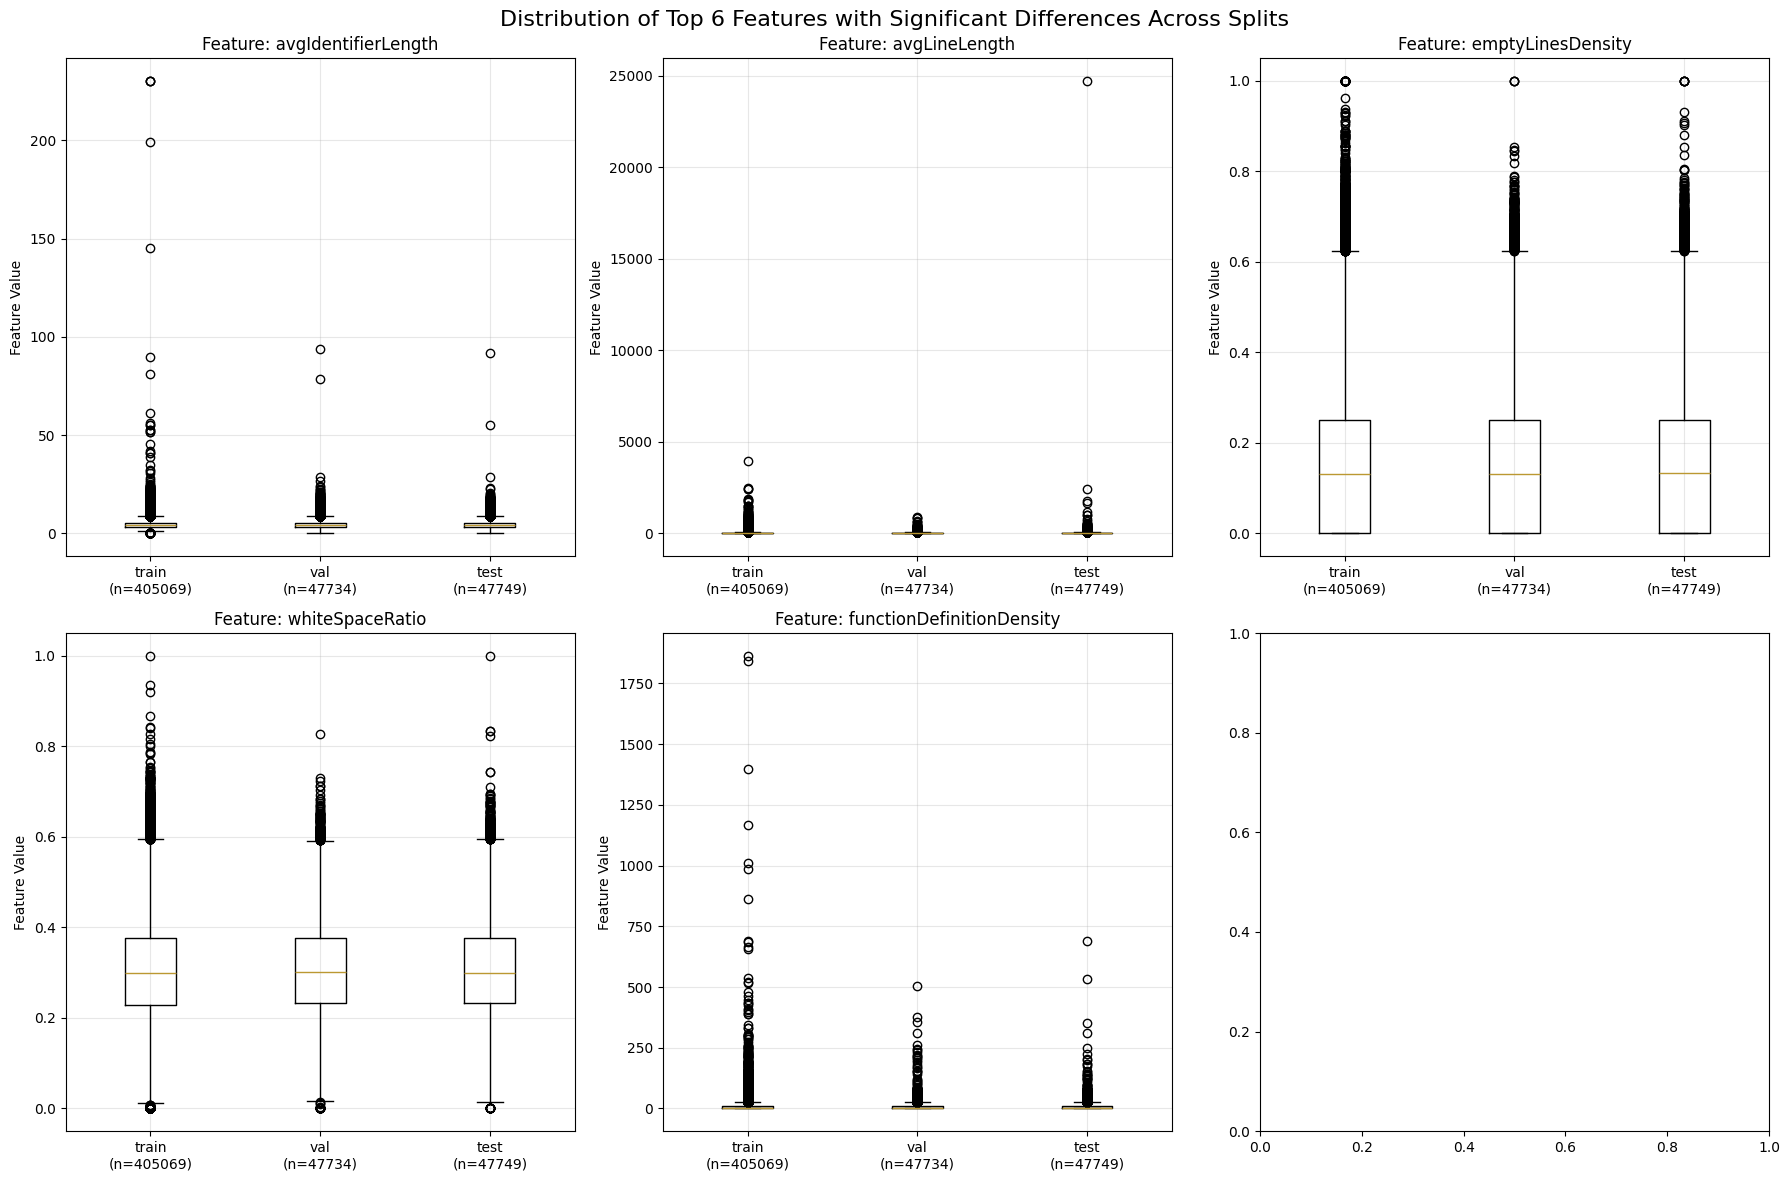

In [9]:
# Visualize feature distributions for top differing features
if len(significant_features) > 0:
    # Select top 6 features with most significant differences
    top_6_features = significant_features.nsmallest(6, 'min_p_value')['feature'].tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(top_6_features):
        # Create box plots for each split
        data_to_plot = []
        labels = []
        
        for split in ['train', 'val', 'test']:
            split_data = all_features[all_features['split'] == split][feature]
            data_to_plot.append(split_data)
            labels.append(f'{split}\n(n={len(split_data)})')
        
        axes[i].boxplot(data_to_plot, labels=labels)
        axes[i].set_title(f'Feature: {feature}')
        axes[i].set_ylabel('Feature Value')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Distribution of Top 6 Features with Significant Differences Across Splits', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No features with significantly different distributions found.")

## 7. Check Target Distribution Balance

In [10]:
def analyze_target_balance(datasets):
    """Analyze target distribution balance across splits"""
    
    target_analysis = {}
    
    for split_name, dataset in datasets.items():
        targets = [sample['target_binary'] for sample in dataset]
        target_counts = Counter(targets)
        
        total = len(targets)
        class_0_count = target_counts.get(0, 0)
        class_1_count = target_counts.get(1, 0)
        
        class_0_pct = (class_0_count / total) * 100
        class_1_pct = (class_1_count / total) * 100
        
        # Calculate class imbalance ratio
        imbalance_ratio = max(class_0_count, class_1_count) / min(class_0_count, class_1_count) if min(class_0_count, class_1_count) > 0 else float('inf')
        
        target_analysis[split_name] = {
            'total_samples': total,
            'class_0_count': class_0_count,
            'class_1_count': class_1_count,
            'class_0_percentage': class_0_pct,
            'class_1_percentage': class_1_pct,
            'imbalance_ratio': imbalance_ratio
        }
    
    return target_analysis

# Analyze target balance
print("Analyzing target distribution balance...")
target_analysis = analyze_target_balance(datasets)

print("\nTarget distribution analysis:")
print("-" * 80)
print(f"{'Split':<12} {'Total':<8} {'Class 0':<10} {'Class 1':<10} {'Class 0 %':<10} {'Class 1 %':<10} {'Imbalance':<10}")
print("-" * 80)

for split_name, analysis in target_analysis.items():
    print(f"{split_name:<12} {analysis['total_samples']:<8} {analysis['class_0_count']:<10} "
          f"{analysis['class_1_count']:<10} {analysis['class_0_percentage']:<10.1f} "
          f"{analysis['class_1_percentage']:<10.1f} {analysis['imbalance_ratio']:<10.2f}")

# Check for significant differences in class proportions
print("\nClass proportion comparison:")
train_prop = target_analysis['train']['class_1_percentage']
val_prop = target_analysis['val']['class_1_percentage']
test_prop = target_analysis['test']['class_1_percentage']

print(f"Class 1 proportion - Train: {train_prop:.2f}%, Val: {val_prop:.2f}%, Test: {test_prop:.2f}%")

# Calculate differences
train_val_diff = abs(train_prop - val_prop)
train_test_diff = abs(train_prop - test_prop)
val_test_diff = abs(val_prop - test_prop)

print(f"Absolute differences:")
print(f"  Train vs Val: {train_val_diff:.2f} percentage points")
print(f"  Train vs Test: {train_test_diff:.2f} percentage points")
print(f"  Val vs Test: {val_test_diff:.2f} percentage points")

# Flag potential issues
threshold = 5.0  # 5% difference threshold
if max(train_val_diff, train_test_diff, val_test_diff) > threshold:
    print(f"\n⚠️  WARNING: Target class proportions differ by more than {threshold}% between splits!")
    print("This could indicate potential bias or stratification issues.")
else:
    print(f"\n✅ Target class proportions are well-balanced across splits (differences < {threshold}%).")

Analyzing target distribution balance...


KeyboardInterrupt: 

## 8. Visualize Data Leakage Results

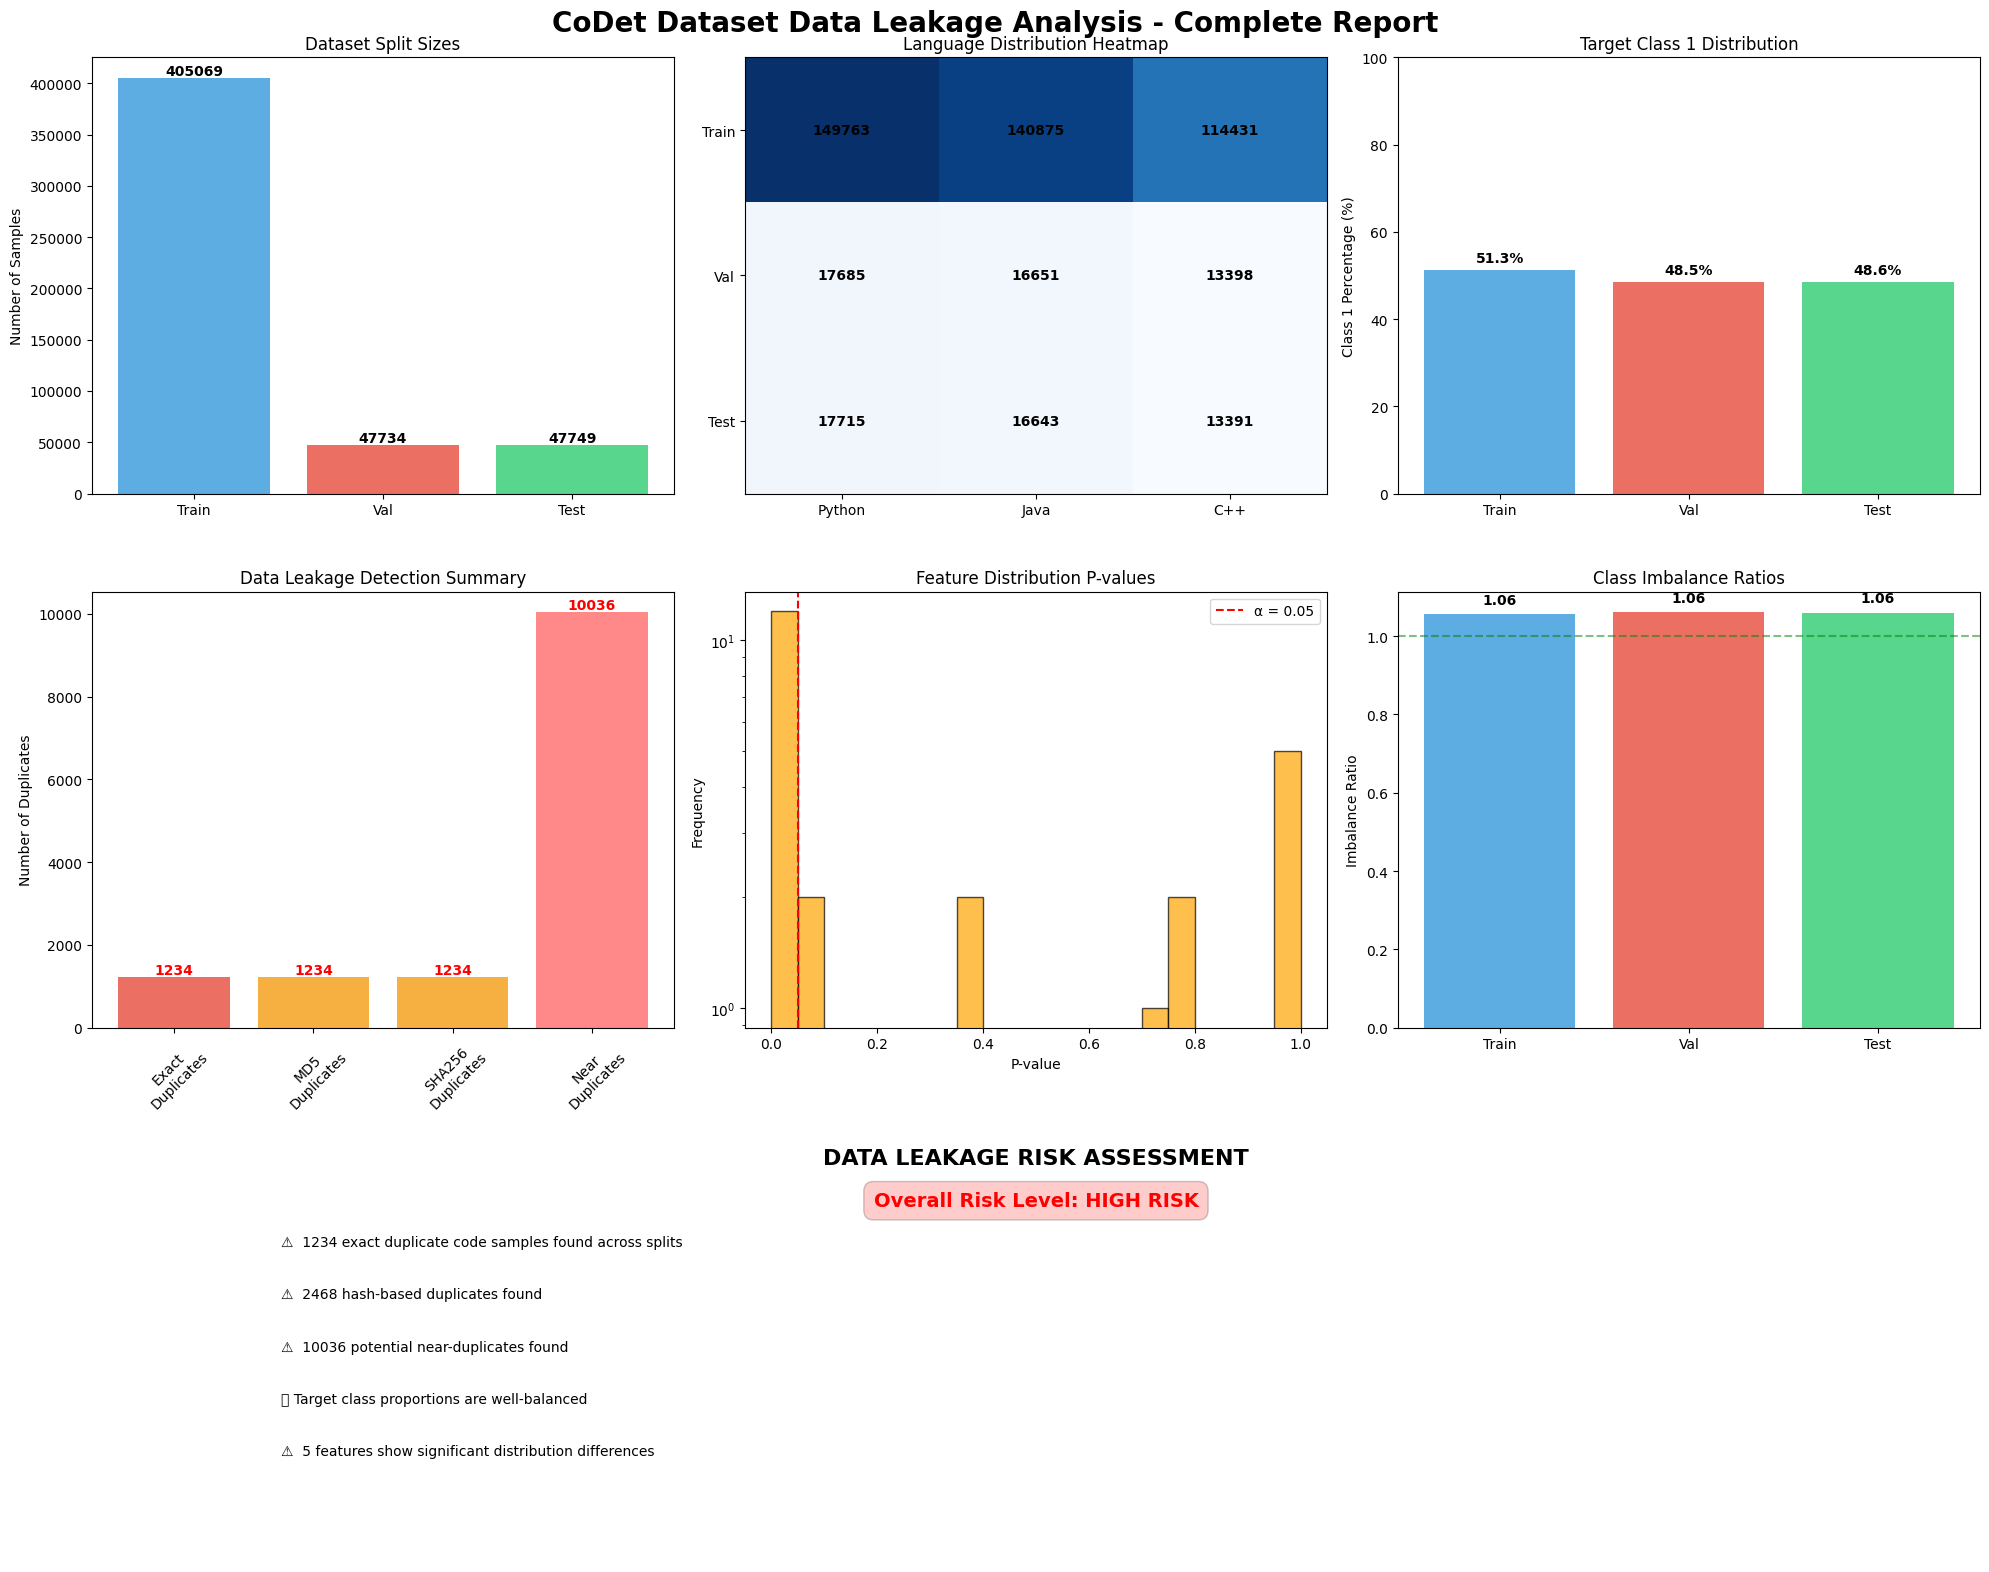


DATA LEAKAGE ANALYSIS SUMMARY
Overall Risk Level: HIGH RISK

Detailed Findings:
  ⚠️  1234 exact duplicate code samples found across splits
  ⚠️  2468 hash-based duplicates found
  ⚠️  10036 potential near-duplicates found
  ✅ Target class proportions are well-balanced
  ⚠️  5 features show significant distribution differences


In [ ]:
# Create comprehensive visualization of data leakage analysis
fig = plt.figure(figsize=(20, 16))

# 1. Dataset split overview
ax1 = plt.subplot(3, 3, 1)
split_names = ['Train', 'Val', 'Test']
split_sizes = [len(train), len(val), len(test)]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(split_names, split_sizes, color=colors, alpha=0.8)
ax1.set_ylabel('Number of Samples')
ax1.set_title('Dataset Split Sizes')
for bar, size in zip(bars, split_sizes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50, str(size), 
             ha='center', va='bottom', fontweight='bold')

# 2. Language distribution heatmap
ax2 = plt.subplot(3, 3, 2)
lang_data = np.array([[train_lang.get(lang, 0) for lang in ['python', 'java', 'cpp']],
                      [val_lang.get(lang, 0) for lang in ['python', 'java', 'cpp']],
                      [test_lang.get(lang, 0) for lang in ['python', 'java', 'cpp']]])
im = ax2.imshow(lang_data, cmap='Blues', aspect='auto')
ax2.set_xticks(range(3))
ax2.set_xticklabels(['Python', 'Java', 'C++'])
ax2.set_yticks(range(3))
ax2.set_yticklabels(['Train', 'Val', 'Test'])
ax2.set_title('Language Distribution Heatmap')
# Add text annotations
for i in range(3):
    for j in range(3):
        ax2.text(j, i, str(lang_data[i, j]), ha='center', va='center', fontweight='bold')

# 3. Target distribution comparison
ax3 = plt.subplot(3, 3, 3)
target_props = [target_analysis[split]['class_1_percentage'] for split in ['train', 'val', 'test']]
bars = ax3.bar(split_names, target_props, color=colors, alpha=0.8)
ax3.set_ylabel('Class 1 Percentage (%)')
ax3.set_title('Target Class 1 Distribution')
ax3.set_ylim(0, 100)
for bar, prop in zip(bars, target_props):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1, f'{prop:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# 4. Duplicate detection summary
ax4 = plt.subplot(3, 3, 4)
duplicate_counts = [
    len(exact_duplicates) if exact_duplicates else 0,
    len(hash_duplicates.get('md5', {})) if hash_duplicates.get('md5') else 0,
    len(hash_duplicates.get('sha256', {})) if hash_duplicates.get('sha256') else 0,
    len(near_duplicates) if near_duplicates else 0
]
duplicate_types = ['Exact\nDuplicates', 'MD5\nDuplicates', 'SHA256\nDuplicates', 'Near\nDuplicates']
bars = ax4.bar(duplicate_types, duplicate_counts, color=['#e74c3c', '#f39c12', '#f39c12', '#ff6b6b'], alpha=0.8)
ax4.set_ylabel('Number of Duplicates')
ax4.set_title('Data Leakage Detection Summary')
ax4.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, duplicate_counts):
    if count > 0:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1, str(count), 
                 ha='center', va='bottom', fontweight='bold', color='red')

# 5. Feature distribution differences (if any significant features found)
ax5 = plt.subplot(3, 3, 5)
if len(significant_features) > 0:
    # Show p-value distribution
    p_values = np.concatenate([
        distribution_comparison['train_val_p_value'].values,
        distribution_comparison['train_test_p_value'].values,
        distribution_comparison['val_test_p_value'].values
    ])
    ax5.hist(p_values, bins=20, alpha=0.7, color='orange', edgecolor='black')
    ax5.axvline(x=0.05, color='red', linestyle='--', label='α = 0.05')
    ax5.set_xlabel('P-value')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Feature Distribution P-values')
    ax5.legend()
    ax5.set_yscale('log')
else:
    ax5.text(0.5, 0.5, 'No significant\nfeature distribution\ndifferences found', 
             ha='center', va='center', transform=ax5.transAxes, fontsize=12,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    ax5.set_title('Feature Distribution Analysis')
    ax5.set_xticks([])
    ax5.set_yticks([])

# 6. Class imbalance comparison
ax6 = plt.subplot(3, 3, 6)
imbalance_ratios = [target_analysis[split]['imbalance_ratio'] for split in ['train', 'val', 'test']]
bars = ax6.bar(split_names, imbalance_ratios, color=colors, alpha=0.8)
ax6.set_ylabel('Imbalance Ratio')
ax6.set_title('Class Imbalance Ratios')
ax6.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Perfect Balance')
for bar, ratio in zip(bars, imbalance_ratios):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{ratio:.2f}', 
             ha='center', va='bottom', fontweight='bold')

# 7. Overall data leakage risk assessment
ax7 = plt.subplot(3, 3, (7, 9))
ax7.axis('off')

# Calculate overall risk score
risk_factors = []
risk_messages = []

# Check for exact duplicates
if len(exact_duplicates) > 0:
    risk_factors.append('HIGH')
    risk_messages.append(f"⚠️  {len(exact_duplicates)} exact duplicate code samples found across splits")
else:
    risk_messages.append("✅ No exact duplicate code samples found")

# Check for hash duplicates
total_hash_duplicates = sum(len(dups) for dups in hash_duplicates.values())
if total_hash_duplicates > 0:
    risk_factors.append('HIGH')
    risk_messages.append(f"⚠️  {total_hash_duplicates} hash-based duplicates found")
else:
    risk_messages.append("✅ No hash-based duplicates found")

# Check for near duplicates
if len(near_duplicates) > 0:
    risk_factors.append('MEDIUM')
    risk_messages.append(f"⚠️  {len(near_duplicates)} potential near-duplicates found")
else:
    risk_messages.append("✅ No near-duplicates detected")

# Check target distribution differences
max_target_diff = max(train_val_diff, train_test_diff, val_test_diff)
if max_target_diff > 5.0:
    risk_factors.append('MEDIUM')
    risk_messages.append(f"⚠️  Target class proportions differ by up to {max_target_diff:.1f}%")
else:
    risk_messages.append("✅ Target class proportions are well-balanced")

# Check feature distribution differences
if len(significant_features) > len(feature_names) * 0.1:  # More than 10% of features differ significantly
    risk_factors.append('MEDIUM')
    risk_messages.append(f"⚠️  {len(significant_features)} features show significant distribution differences")
else:
    risk_messages.append("✅ Feature distributions are consistent across splits")

# Determine overall risk level
if 'HIGH' in risk_factors:
    overall_risk = 'HIGH RISK'
    risk_color = 'red'
elif 'MEDIUM' in risk_factors:
    overall_risk = 'MEDIUM RISK'
    risk_color = 'orange'
else:
    overall_risk = 'LOW RISK'
    risk_color = 'green'

# Display risk assessment
ax7.text(0.5, 0.95, 'DATA LEAKAGE RISK ASSESSMENT', ha='center', va='top', 
         fontsize=16, fontweight='bold', transform=ax7.transAxes)

ax7.text(0.5, 0.85, f'Overall Risk Level: {overall_risk}', ha='center', va='top', 
         fontsize=14, fontweight='bold', color=risk_color, transform=ax7.transAxes,
         bbox=dict(boxstyle='round,pad=0.5', facecolor=risk_color, alpha=0.2))

# Display individual risk messages
y_pos = 0.75
for message in risk_messages:
    ax7.text(0.1, y_pos, message, ha='left', va='top', fontsize=10, 
             transform=ax7.transAxes, wrap=True)
    y_pos -= 0.12

plt.suptitle('CoDet Dataset Data Leakage Analysis - Complete Report', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("DATA LEAKAGE ANALYSIS SUMMARY")
print("="*80)
print(f"Overall Risk Level: {overall_risk}")
print("\nDetailed Findings:")
for message in risk_messages:
    print(f"  {message}")
print("="*80)

## 9. Remove Duplicates and Save Cleaned Dataset

### Duplicate Detection Criteria Used:

**Primary Method: Exact String Matching**
- **Field Used**: `cleaned_code` (the preprocessed code field in the dataset)
- **Method**: Direct string comparison (byte-for-byte identical code)
- **Scope**: Cross-split comparison (only removes samples that appear in multiple splits)
- **Case Sensitivity**: Yes (exact match required)

**Supplementary Methods: Hash-based Detection**
- **Hash Functions**: MD5 and SHA-256 cryptographic hashes of `cleaned_code`
- **Purpose**: Additional verification and potential detection of encoding variations
- **Use**: Cross-validation of exact string matching results

**Prefix Matching Detection**
- **Method**: Identifies code samples where one is a prefix of another
- **Threshold**: Configurable minimum prefix length
- **Purpose**: Detect potential code truncation or partial duplicates

### ⚠️ **UPDATED DEDUPLICATION STRATEGY** ⚠️

**New Removal Priority (Training Data Preservation):**

1. **Train + Val duplicates** → Remove from **val** (preserve training data)
2. **Train + Test duplicates** → Remove from **test** (preserve training data)  
3. **Val + Test duplicates** → Remove from **val** (preserve test data over validation)
4. **All three splits** → Remove from **val AND test** (preserve training data at all costs)

**Rationale**: Training data is the most critical for model learning. It's better to have smaller but clean validation/test sets than to lose valuable training examples that could improve model performance.

**Impact**: This approach maximizes the amount of training data available while still maintaining clean evaluation sets free from data leakage.

In [12]:
def identify_indices_to_remove(exact_duplicates, datasets):
    """
    Identify which sample indices to remove from each split to eliminate duplicates.
    
    NEW STRATEGY - Prioritize keeping training data:
    - train > val > test (keep training data, remove from val/test first)
    """
    
    indices_to_remove = {
        'train': set(),
        'val': set(),
        'test': set()
    }
    
    removal_stats = {
        'train_val': 0,
        'train_test': 0,
        'val_test': 0,
        'all_three': 0,
        'total_removed': 0
    }
    
    print("Processing duplicate code samples for removal...")
    
    for code, occurrences in exact_duplicates.items():
        # Get which splits contain this code
        splits_with_code = {}
        for split_name, idx in occurrences:
            if split_name not in splits_with_code:
                splits_with_code[split_name] = []
            splits_with_code[split_name].append(idx)
        
        splits_involved = set(splits_with_code.keys())
        
        if splits_involved == {'train', 'val', 'test'}:
            # All three splits - remove from val and test, keep in train
            indices_to_remove['val'].update(splits_with_code['val'])
            indices_to_remove['test'].update(splits_with_code['test'])
            removal_stats['all_three'] += 1
            removal_stats['total_removed'] += len(splits_with_code['val']) + len(splits_with_code['test'])
            
        elif splits_involved == {'train', 'val'}:
            # Train and val - remove from val, keep in train
            indices_to_remove['val'].update(splits_with_code['val'])
            removal_stats['train_val'] += 1
            removal_stats['total_removed'] += len(splits_with_code['val'])
            
        elif splits_involved == {'train', 'test'}:
            # Train and test - remove from test, keep in train
            indices_to_remove['test'].update(splits_with_code['test'])
            removal_stats['train_test'] += 1
            removal_stats['total_removed'] += len(splits_with_code['test'])
            
        elif splits_involved == {'val', 'test'}:
            # Val and test - remove from val (keep test over val for evaluation)
            indices_to_remove['val'].update(splits_with_code['val'])
            removal_stats['val_test'] += 1
            removal_stats['total_removed'] += len(splits_with_code['val'])
    
    return indices_to_remove, removal_stats

# Identify indices to remove
if exact_duplicates:
    indices_to_remove, removal_stats = identify_indices_to_remove(exact_duplicates, datasets)
    
    print(f"\nDuplicate removal plan:")
    print(f"  Train-Val duplicates: {removal_stats['train_val']} (removing from val)")
    print(f"  Train-Test duplicates: {removal_stats['train_test']} (removing from test)")
    print(f"  Val-Test duplicates: {removal_stats['val_test']} (removing from val)")
    print(f"  All-three duplicates: {removal_stats['all_three']} (removing from val and test)")
    print(f"  Total sample instances to remove: {removal_stats['total_removed']}")
    
    print(f"\nIndices to remove per split:")
    for split_name in ['train', 'val', 'test']:
        count = len(indices_to_remove[split_name])
        print(f"  {split_name}: {count} samples")

else:
    indices_to_remove = {'train': set(), 'val': set(), 'test': set()}

Processing duplicate code samples for removal...

Duplicate removal plan:
  Train-Val duplicates: 555 (removing from val)
  Train-Test duplicates: 595 (removing from test)
  Val-Test duplicates: 49 (removing from val)
  All-three duplicates: 35 (removing from val and test)
  Total sample instances to remove: 1402

Indices to remove per split:
  train: 0 samples
  val: 699 samples
  test: 703 samples


In [13]:
def create_cleaned_datasets(datasets, indices_to_remove):
    """
    Create new datasets with duplicate samples removed
    """
    
    cleaned_datasets = {}
    
    for split_name, dataset in datasets.items():
        remove_indices = indices_to_remove[split_name]
        
        print(f"Processing {split_name} split...")
        print(f"  Original size: {len(dataset)}")
        print(f"  Removing: {len(remove_indices)} samples")
        
        # Create new dataset excluding the indices to remove
        cleaned_samples = []
        for i, sample in enumerate(dataset):
            if i not in remove_indices:
                cleaned_samples.append(sample)
        
        # Convert back to HuggingFace Dataset format
        from datasets import Dataset
        
        # Extract all fields from the first sample to understand the structure
        if cleaned_samples:
            sample_fields = cleaned_samples[0].keys()
            cleaned_dict = {field: [] for field in sample_fields}
            
            for sample in cleaned_samples:
                for field in sample_fields:
                    cleaned_dict[field].append(sample[field])
            
            cleaned_datasets[split_name] = Dataset.from_dict(cleaned_dict)
        else:
            # Handle edge case where all samples are removed (shouldn't happen with our logic)
            cleaned_datasets[split_name] = Dataset.from_dict({})
        
        print(f"  New size: {len(cleaned_datasets[split_name])}")
        print(f"  Reduction: {len(dataset) - len(cleaned_datasets[split_name])} samples")
    
    return cleaned_datasets

# Create cleaned datasets
if exact_duplicates:
    print("Creating cleaned datasets...")
    cleaned_datasets = create_cleaned_datasets(datasets, indices_to_remove)
    
    # Update our working datasets
    train_cleaned = cleaned_datasets['train']
    val_cleaned = cleaned_datasets['val'] 
    test_cleaned = cleaned_datasets['test']
    
    print(f"\nCleaned dataset sizes:")
    print(f"  Train: {len(train)} → {len(train_cleaned)} (removed {len(train) - len(train_cleaned)})")
    print(f"  Val: {len(val)} → {len(val_cleaned)} (removed {len(val) - len(val_cleaned)})")
    print(f"  Test: {len(test)} → {len(test_cleaned)} (removed {len(test) - len(test_cleaned)})")
    
else:
    print("No duplicates to remove - using original datasets")
    train_cleaned = train
    val_cleaned = val
    test_cleaned = test

Creating cleaned datasets...
Processing train split...
  Original size: 405069
  Removing: 0 samples
  New size: 405069
  Reduction: 0 samples
Processing val split...
  Original size: 47734
  Removing: 699 samples
  New size: 405069
  Reduction: 0 samples
Processing val split...
  Original size: 47734
  Removing: 699 samples
  New size: 47035
  Reduction: 699 samples
Processing test split...
  Original size: 47749
  Removing: 703 samples
  New size: 47035
  Reduction: 699 samples
Processing test split...
  Original size: 47749
  Removing: 703 samples
  New size: 47046
  Reduction: 703 samples

Cleaned dataset sizes:
  Train: 405069 → 405069 (removed 0)
  Val: 47734 → 47035 (removed 699)
  Test: 47749 → 47046 (removed 703)
  New size: 47046
  Reduction: 703 samples

Cleaned dataset sizes:
  Train: 405069 → 405069 (removed 0)
  Val: 47734 → 47035 (removed 699)
  Test: 47749 → 47046 (removed 703)


In [14]:
# Verify deduplication was successful
print("\nVerifying deduplication...")
cleaned_datasets_dict = {'train': train_cleaned, 'val': val_cleaned, 'test': test_cleaned}
verification_duplicates = find_exact_duplicates(cleaned_datasets_dict, 'cleaned_code')

if verification_duplicates:
    print(f"⚠️  WARNING: Still found {len(verification_duplicates)} duplicates after cleaning!")
    print("This might indicate an issue with the deduplication process.")
else:
    print("✅ Verification successful: No duplicates found in cleaned datasets!")

# Display final statistics
print(f"\nFinal dataset statistics:")
print(f"{'Split':<10} {'Original':<10} {'Cleaned':<10} {'Removed':<10} {'% Removed':<10}")
print("-" * 55)

original_sizes = [len(train), len(val), len(test)]
cleaned_sizes = [len(train_cleaned), len(val_cleaned), len(test_cleaned)]
split_names = ['Train', 'Val', 'Test']

for i, split_name in enumerate(split_names):
    original = original_sizes[i]
    cleaned = cleaned_sizes[i]
    removed = original - cleaned
    pct_removed = (removed / original) * 100 if original > 0 else 0
    
    print(f"{split_name:<10} {original:<10} {cleaned:<10} {removed:<10} {pct_removed:<10.2f}%")


Verifying deduplication...
✅ Verification successful: No duplicates found in cleaned datasets!

Final dataset statistics:
Split      Original   Cleaned    Removed    % Removed 
-------------------------------------------------------
Train      405069     405069     0          0.00      %
Val        47734      47035      699        1.46      %
Test       47749      47046      703        1.47      %
✅ Verification successful: No duplicates found in cleaned datasets!

Final dataset statistics:
Split      Original   Cleaned    Removed    % Removed 
-------------------------------------------------------
Train      405069     405069     0          0.00      %
Val        47734      47035      699        1.46      %
Test       47749      47046      703        1.47      %


In [15]:
# Save cleaned datasets
import os
from datetime import datetime

def save_cleaned_datasets(train_cleaned, val_cleaned, test_cleaned, base_path='../../data/'):
    """
    Save the cleaned datasets to disk in multiple formats
    """
    
    # Create output directory with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join(base_path, f'codet_cleaned_{timestamp}')
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Saving cleaned datasets to: {output_dir}")
    
    # Save as HuggingFace datasets (recommended for later use)
    train_cleaned.save_to_disk(os.path.join(output_dir, 'train'))
    val_cleaned.save_to_disk(os.path.join(output_dir, 'val'))
    test_cleaned.save_to_disk(os.path.join(output_dir, 'test'))
    
    print(f"✅ Datasets saved as HuggingFace Dataset format in: {output_dir}")
    
    # Also save as JSON for easy inspection
    train_cleaned.to_json(os.path.join(output_dir, 'train_cleaned.jsonl'))
    val_cleaned.to_json(os.path.join(output_dir, 'val_cleaned.jsonl'))
    test_cleaned.to_json(os.path.join(output_dir, 'test_cleaned.jsonl'))
    
    print(f"✅ Datasets also saved as JSONL files for easy inspection")
    
    # Save metadata about the cleaning process
    metadata = {
        'cleaning_timestamp': timestamp,
        'original_sizes': {
            'train': len(train),
            'val': len(val),
            'test': len(test)
        },
        'cleaned_sizes': {
            'train': len(train_cleaned),
            'val': len(val_cleaned),
            'test': len(test_cleaned)
        },
        'removed_counts': {
            'train': len(train) - len(train_cleaned),
            'val': len(val) - len(val_cleaned),
            'test': len(test) - len(test_cleaned)
        }
    }
    
    if exact_duplicates:
        metadata['removal_stats'] = removal_stats
        metadata['duplicates_found'] = len(exact_duplicates)
    
    import json
    with open(os.path.join(output_dir, 'cleaning_metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✅ Cleaning metadata saved to: {os.path.join(output_dir, 'cleaning_metadata.json')}")
    
    return output_dir

# Save the cleaned datasets
if exact_duplicates or True:  # Save even if no duplicates for completeness
    saved_path = save_cleaned_datasets(train_cleaned, val_cleaned, test_cleaned)
    
    print(f"\n🎉 Dataset cleaning complete!")
    print(f"📁 Cleaned datasets saved to: {saved_path}")
    print(f"\nTo use the cleaned datasets in future code:")
    print(f"```python")
    print(f"from datasets import load_from_disk")
    print(f"train_clean = load_from_disk('{saved_path}/train')")
    print(f"val_clean = load_from_disk('{saved_path}/val')")
    print(f"test_clean = load_from_disk('{saved_path}/test')")
    print(f"```")
else:
    print("No duplicates found, so no cleaning was necessary.")

Saving cleaned datasets to: ../../data/codet_cleaned_20250812_201438


Saving the dataset (1/1 shards): 100%|██████████| 47046/47046 [00:01<00:00, 45491.46 examples/s]



✅ Datasets saved as HuggingFace Dataset format in: ../../data/codet_cleaned_20250812_201438


Creating json from Arrow format: 100%|██████████| 48/48 [00:00<00:00, 59.98ba/s]

✅ Datasets also saved as JSONL files for easy inspection
✅ Cleaning metadata saved to: ../../data/codet_cleaned_20250812_201438/cleaning_metadata.json

🎉 Dataset cleaning complete!
📁 Cleaned datasets saved to: ../../data/codet_cleaned_20250812_201438

To use the cleaned datasets in future code:
```python
from datasets import load_from_disk
train_clean = load_from_disk('../../data/codet_cleaned_20250812_201438/train')
val_clean = load_from_disk('../../data/codet_cleaned_20250812_201438/val')
test_clean = load_from_disk('../../data/codet_cleaned_20250812_201438/test')
```


## 10. Create Updated Dataset Class

To make it easy to use the cleaned datasets in your existing codebase, let's create a helper function that can be integrated into your dataset loading pipeline.

In [ ]:
def create_dataset_loader_code(cleaned_data_path):
    """
    Generate code for a dataset loader that can be integrated into your existing codebase
    """
    
    code_template = f'''
# Add this function to your data/dataset.py file or create a new file

import os
from datasets import load_from_disk
from typing import List, Tuple, Union

class CoDeTM4Cleaned:
    """
    Dataset loader for the cleaned CoDeTM4 dataset (duplicates removed).
    Use this instead of the original CoDeTM4 class to avoid data leakage.
    """
    
    def __init__(self, cleaned_data_path: str = "{cleaned_data_path}"):
        self.cleaned_data_path = cleaned_data_path
        self._train = None
        self._val = None
        self._test = None
    
    def get_dataset(self, splits: List[str], **kwargs) -> Union[Tuple, object]:
        """
        Load the requested dataset splits.
        
        Args:
            splits: List of split names ['train', 'val', 'test']
            **kwargs: Additional arguments (maintained for compatibility)
            
        Returns:
            Tuple of datasets or single dataset depending on splits requested
        """
        
        datasets = []
        
        for split in splits:
            if split == 'train':
                if self._train is None:
                    self._train = load_from_disk(os.path.join(self.cleaned_data_path, 'train'))
                datasets.append(self._train)
            elif split == 'val':
                if self._val is None:
                    self._val = load_from_disk(os.path.join(self.cleaned_data_path, 'val'))
                datasets.append(self._val)
            elif split == 'test':
                if self._test is None:
                    self._test = load_from_disk(os.path.join(self.cleaned_data_path, 'test'))
                datasets.append(self._test)
            else:
                raise ValueError(f"Unknown split: {{split}}")
        
        if len(datasets) == 1:
            return datasets[0]
        else:
            return tuple(datasets)

# Usage example:
# from your_module import CoDeTM4Cleaned
# 
# # Replace your original dataset loading:
# # train, val, test = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)
# 
# # With this:
# train, val, test = CoDeTM4Cleaned('{cleaned_data_path}').get_dataset(['train','val','test'])
'''
    
    return code_template

# Generate the dataset loader code
if 'saved_path' in locals():
    loader_code = create_dataset_loader_code(saved_path)
    
    print("Dataset Loader Code Generated:")
    print("=" * 60)
    print(loader_code)
    
    # Save the loader code to a file for easy copy-paste
    with open(os.path.join(saved_path, 'dataset_loader.py'), 'w') as f:
        f.write(loader_code)
    
    print(f"\n✅ Dataset loader code saved to: {os.path.join(saved_path, 'dataset_loader.py')}")
    print("\nNext steps:")
    print("1. Copy the CoDeTM4Cleaned class to your data/dataset.py file")
    print("2. Update your existing code to use CoDeTM4Cleaned instead of CoDeTM4")
    print("3. The API is the same, so minimal code changes should be needed!")

else:
    print("No cleaned datasets were saved, so no loader code generated.")

Dataset Loader Code Generated:

# Add this function to your data/dataset.py file or create a new file

import os
from datasets import load_from_disk
from typing import List, Tuple, Union

class CoDeTM4Cleaned:
    """
    Dataset loader for the cleaned CoDeTM4 dataset (duplicates removed).
    Use this instead of the original CoDeTM4 class to avoid data leakage.
    """
    
    def __init__(self, cleaned_data_path: str = "../../data/codet_cleaned_20250812_174630"):
        self.cleaned_data_path = cleaned_data_path
        self._train = None
        self._val = None
        self._test = None
    
    def get_dataset(self, splits: List[str], **kwargs) -> Union[Tuple, object]:
        """
        Load the requested dataset splits.
        
        Args:
            splits: List of split names ['train', 'val', 'test']
            **kwargs: Additional arguments (maintained for compatibility)
            
        Returns:
            Tuple of datasets or single dataset depending on splits 

In [ ]:
def create_full_codet_class(cleaned_data_path):
    """
    Create a complete CoDeTM4Cleaned class file that can be used anywhere in the codebase.
    """
    
    class_code = f'''import logging
import os
from typing import Tuple, Union, List
from datasets import Dataset, load_from_disk
from datasets import ClassLabel

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


class CoDeTM4Cleaned:
    """
    Dataset class for loading and processing the cleaned CoDet-M4 dataset (duplicates removed).
    
    This class provides the same API as the original CoDeTM4 class but loads from
    pre-cleaned datasets where duplicates have been removed to prevent data leakage.
    
    Default path: {cleaned_data_path}
    """

    # Dataset column names - available even before loading
    COLUMN_NAMES = [
        'code', 'target', 'model', 'language', 'source', 'features', 'cleaned_code', 'split'
    ]

    def __init__(self, cleaned_data_path: str = "{cleaned_data_path}"):
        """
        Initialize the CoDeTM4Cleaned dataset class.

        Args:
            cleaned_data_path (str): Path to the directory containing cleaned datasets.
                                   Should contain subdirectories: train/, val/, test/

        Raises:
            ValueError: If cleaned_data_path is invalid or does not exist.
            FileNotFoundError: If required split directories are not found.
        """
        if not os.path.isdir(cleaned_data_path):
            raise ValueError(
                f"Cleaned data path '{{cleaned_data_path}}' does not exist or is not a directory"
            )
        
        self.cleaned_data_path = cleaned_data_path
        
        # Check that required split directories exist
        required_splits = ['train', 'val', 'test']
        for split in required_splits:
            split_path = os.path.join(cleaned_data_path, split)
            if not os.path.isdir(split_path):
                raise FileNotFoundError(
                    f"Required split directory '{{split_path}}' not found. "
                    f"Expected structure: {{cleaned_data_path}}/{{{{train,val,test}}}}/"
                )
        
        # Cache for loaded datasets
        self._train = None
        self._val = None
        self._test = None
        
        logger.info(f"Initialized CoDeTM4Cleaned with cleaned data from: {{cleaned_data_path}}")

    @staticmethod
    def get_column_names() -> List[str]:
        """Get the list of available column names in the CoDet-M4 dataset."""
        return CoDeTM4Cleaned.COLUMN_NAMES.copy()

    def _load_split(self, split_name: str) -> Dataset:
        """Load a specific split from disk."""
        if split_name not in ['train', 'val', 'test']:
            raise ValueError(f"Invalid split '{{split_name}}'. Must be one of ['train', 'val', 'test']")
        
        try:
            split_path = os.path.join(self.cleaned_data_path, split_name)
            dataset = load_from_disk(split_path)
            
            # Ensure target_binary column exists with proper type
            if 'target_binary' not in dataset.column_names:
                logger.warning(f"target_binary column not found in {{split_name}} split. Adding it...")
                def map_target_binary(example):
                    target_binary = 0 if example["target"] == "human" else 1
                    return {{"target_binary": target_binary}}
                
                dataset = dataset.map(map_target_binary, num_proc=8)
                dataset = dataset.cast_column("target_binary", ClassLabel(names=["human", "ai"]))
            
            logger.info(f"Loaded {{split_name}} split: {{len(dataset)}} samples")
            return dataset
            
        except Exception as e:
            raise RuntimeError(f"Failed to load {{split_name}} split from {{split_path}}: {{str(e)}}")

    def _filter_columns(self, dataset: Dataset, columns: Union[str, List[str]]) -> Dataset:
        """Filter dataset columns based on the columns parameter."""
        if columns == 'all':
            return dataset
        
        if isinstance(columns, str):
            columns = [columns]
        
        # Validate columns exist in dataset
        available_columns = list(dataset.column_names)
        invalid_columns = [col for col in columns if col not in available_columns]
        if invalid_columns:
            raise ValueError(f"Columns {{invalid_columns}} not found in dataset. Available columns: {{available_columns}}")
        
        # Always include target_binary if it exists
        if 'target_binary' in available_columns and 'target_binary' not in columns:
            columns = columns + ['target_binary']
        
        return dataset.select_columns(columns)

    def _get_train_subset(self, dataset: Dataset, subset_fraction: float) -> Dataset:
        """Get a stratified subset of the training dataset to maintain class balance."""
        if not 0 < subset_fraction <= 1.0:
            raise ValueError("train_subset must be between 0 and 1.0")
        
        if subset_fraction == 1.0:
            return dataset
        
        # Use stratified sampling based on target_binary to maintain class balance
        try:
            subset_data = dataset.train_test_split(
                train_size=subset_fraction,
                seed=42,
                stratify_by_column='target_binary'
            )
            return subset_data['train']
        except Exception as e:
            # Fallback to regular sampling if stratified sampling fails
            logger.warning(f"Stratified sampling failed: {{e}}. Using regular sampling.")
            total_samples = len(dataset)
            subset_size = int(total_samples * subset_fraction)
            return dataset.select(range(subset_size))

    def _limit_split_size(self, dataset: Dataset, max_size: int) -> Dataset:
        """Limit the size of a dataset split using stratified sampling."""
        if len(dataset) <= max_size:
            return dataset
        
        # Calculate fraction to keep
        fraction = max_size / len(dataset)
        
        # Use stratified sampling if target_binary exists
        try:
            if 'target_binary' in dataset.column_names:
                limited_data = dataset.train_test_split(
                    train_size=fraction,
                    seed=42,
                    stratify_by_column='target_binary'
                )
                return limited_data['train']
            else:
                # Fallback to regular sampling
                return dataset.select(range(max_size))
        except Exception as e:
            logger.warning(f"Stratified sampling failed for split limiting: {{e}}. Using regular sampling.")
            return dataset.select(range(max_size))

    def get_dataset(
        self, 
        split: Union[str, List[str]] = 'all', 
        columns: Union[str, List[str]] = 'all', 
        train_subset: float = 1.0,
        dynamic_split_sizing: bool = False,  # Default to False since data is already cleaned
        max_split_ratio: float = 0.2,
        val_ratio: float = None,
        test_ratio: float = None
    ) -> Union[Dataset, Tuple[Dataset, ...]]:
        """
        Load and process the cleaned CoDet-M4 dataset.
        
        This method provides the same API as the original CoDeTM4.get_dataset() method
        but loads from pre-cleaned datasets.

        Args:
            split (Union[str, List[str]]): Dataset split(s) to load ('train', 'val', 'test', 'all', or list of splits).
            columns (Union[str, List[str]]): Columns to include ('all' or list of column names).
            train_subset (float): Fraction of training data to load (0.0 to 1.0).
            dynamic_split_sizing (bool): Whether to dynamically limit val/test sizes based on train size.
                                        Default False since cleaned data is already properly sized.
            max_split_ratio (float): Maximum ratio of val/test size to train size when dynamic_split_sizing=True.
            val_ratio (float, optional): Specific ratio for validation set size relative to full validation set.
            test_ratio (float, optional): Specific ratio for test set size relative to full test set.

        Returns:
            Union[Dataset, Tuple[Dataset, ...]]: Single dataset if split is string, tuple of datasets if split is list.

        Raises:
            ValueError: If split is invalid or columns are not found.
            RuntimeError: If dataset loading fails.
        """
        # Validate split parameter
        valid_splits = ['train', 'val', 'test', 'all']
        
        # Handle split parameter - convert to list for unified processing
        return_tuple = False
        if isinstance(split, str):
            if split not in valid_splits:
                raise ValueError(f"Invalid split '{{split}}'. Must be one of {{valid_splits}}")
            splits_to_load = [split] if split != 'all' else ['train', 'val', 'test']
        else:
            # split is a list - we need to return a tuple
            return_tuple = True
            invalid_splits = [s for s in split if s not in ['train', 'val', 'test']]
            if invalid_splits:
                raise ValueError(f"Invalid splits {{invalid_splits}}. Must be from ['train', 'val', 'test']")
            splits_to_load = split

        # Load datasets
        datasets = {{}}
        
        for split_name in splits_to_load:
            # Use cached dataset if available
            if split_name == 'train' and self._train is not None:
                datasets[split_name] = self._train
            elif split_name == 'val' and self._val is not None:
                datasets[split_name] = self._val
            elif split_name == 'test' and self._test is not None:
                datasets[split_name] = self._test
            else:
                # Load and cache dataset
                dataset = self._load_split(split_name)
                datasets[split_name] = dataset
                
                # Cache the dataset
                if split_name == 'train':
                    self._train = dataset
                elif split_name == 'val':
                    self._val = dataset
                elif split_name == 'test':
                    self._test = dataset

        # Apply train subset if needed
        if 'train' in datasets and train_subset < 1.0:
            datasets['train'] = self._get_train_subset(datasets['train'], train_subset)
            # Update cache
            self._train = datasets['train']

        # Apply dynamic sizing if requested
        if dynamic_split_sizing and 'train' in datasets:
            train_size = len(datasets['train'])
            
            for split_name in ['val', 'test']:
                if split_name in datasets:
                    original_size = len(datasets[split_name])
                    
                    # Calculate target size
                    if split_name == 'val' and val_ratio is not None:
                        target_size = int(original_size * val_ratio)
                        logger.info(f"Target validation size: {{target_size}} ({{val_ratio:.1%}} of available validation data)")
                    elif split_name == 'test' and test_ratio is not None:
                        target_size = int(original_size * test_ratio)
                        logger.info(f"Target test size: {{target_size}} ({{test_ratio:.1%}} of available test data)")
                    else:
                        target_size = int(train_size * max_split_ratio)
                    
                    if target_size < original_size:
                        datasets[split_name] = self._limit_split_size(datasets[split_name], target_size)
                        logger.info(f"Limited {{split_name}} from {{original_size}} to {{len(datasets[split_name])}} samples")

        # Filter columns for all datasets
        for split_name in datasets:
            datasets[split_name] = self._filter_columns(datasets[split_name], columns)

        # Return results
        if return_tuple:
            return tuple(datasets[split_name] for split_name in splits_to_load)
        elif len(splits_to_load) == 1:
            return datasets[splits_to_load[0]]
        else:
            # Concatenate all splits for 'all' case
            from datasets import concatenate_datasets
            return concatenate_datasets([datasets[split_name] for split_name in splits_to_load])

    def get_info(self) -> dict:
        """Get information about the cleaned dataset."""
        info = {{
            'cleaned_data_path': self.cleaned_data_path,
            'available_splits': ['train', 'val', 'test'],
            'column_names': self.get_column_names()
        }}
        
        # Add size information if datasets are cached
        if self._train is not None:
            info['train_size'] = len(self._train)
        if self._val is not None:
            info['val_size'] = len(self._val)
        if self._test is not None:
            info['test_size'] = len(self._test)
        
        # Load metadata if available
        metadata_path = os.path.join(self.cleaned_data_path, 'cleaning_metadata.json')
        if os.path.exists(metadata_path):
            import json
            try:
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                info['cleaning_metadata'] = metadata
            except Exception as e:
                logger.warning(f"Could not load cleaning metadata: {{e}}")
        
        return info


# Convenience function for quick access
def get_cleaned_codet_dataset(splits=['train', 'val', 'test'], **kwargs):
    """
    Convenience function to quickly load the cleaned CoDet dataset.
    
    Args:
        splits (List[str]): List of splits to load
        **kwargs: Additional arguments passed to get_dataset()
    
    Returns:
        Tuple of datasets or single dataset
    """
    loader = CoDeTM4Cleaned()
    return loader.get_dataset(split=splits, **kwargs)


if __name__ == "__main__":
    # Example usage
    try:
        # Initialize dataset loader
        dataset_loader = CoDeTM4Cleaned()
        
        # Test column names access
        logger.info(f"Available columns: {{CoDeTM4Cleaned.get_column_names()}}")
        
        # Get dataset info
        info = dataset_loader.get_info()
        logger.info(f"Dataset info: {{info}}")
        
        # Load multiple splits (same API as original CoDeTM4)
        logger.info("Loading train, val, and test splits...")
        train, val, test = dataset_loader.get_dataset(split=['train', 'val', 'test'])
        logger.info(f"Train dataset size: {{len(train)}}")
        logger.info(f"Val dataset size: {{len(val)}}")
        logger.info(f"Test dataset size: {{len(test)}}")
        
        # Quick access using convenience function
        logger.info("Using convenience function...")
        train2, val2, test2 = get_cleaned_codet_dataset(['train', 'val', 'test'])
        logger.info(f"Quick access - Train: {{len(train2)}}, Val: {{len(val2)}}, Test: {{len(test2)}}")
        
    except Exception as e:
        logger.error(f"Error: {{e}}")
        logger.info("Make sure the cleaned data path exists and contains train/, val/, test/ directories.")
'''
    
    return class_code

# Create the complete CoDeTM4Cleaned class file
if 'saved_path' in locals():
    print("\\nCreating complete CoDeTM4Cleaned class file...")
    
    # Create the class code
    class_code = create_full_codet_class(saved_path)
    
    # Save to the dataset directory
    class_file_path = "../dataset/codet_m4_cleaned.py"
    with open(class_file_path, 'w') as f:
        f.write(class_code)
    
    print(f"✅ Complete CoDeTM4Cleaned class created at: {class_file_path}")
    
    # Also save in the cleaned data directory for reference
    backup_path = os.path.join(saved_path, 'codet_m4_cleaned.py')
    with open(backup_path, 'w') as f:
        f.write(class_code)
    
    print(f"✅ Backup copy saved at: {backup_path}")
    
    print(f"\\n🎉 You can now use the cleaned dataset from anywhere in your code:")
    print(f"```python")
    print(f"from data.dataset.codet_m4_cleaned import CoDeTM4Cleaned")
    print(f"")
    print(f"# Same API as original CoDeTM4")
    print(f"train, val, test = CoDeTM4Cleaned().get_dataset(['train','val','test'], columns='all')")
    print(f"")
    print(f"# Or use the convenience function")
    print(f"from data.dataset.codet_m4_cleaned import get_cleaned_codet_dataset")
    print(f"train, val, test = get_cleaned_codet_dataset(['train', 'val', 'test'])")
    print(f"```")
    
else:
    print("No cleaned datasets were saved, so no class file created.")